In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection
from tqdm.notebook import tqdm

In [17]:
from sklearn import ensemble, svm
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [3]:
dataframe = pd.read_excel("insurance_claims.xlsx", sheet_name = "insurance_claims")

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 21 columns):
claimid              4415 non-null int64
incident_date        4415 non-null datetime64[ns]
claim_type           4415 non-null int64
uninhabitable        4415 non-null int64
claim_amount         4415 non-null float64
fraudulent           3415 non-null float64
policyid             4415 non-null object
policy_date          4415 non-null datetime64[ns]
coverage             4415 non-null int64
deductible           4415 non-null int64
townsize             4415 non-null int64
gender               4415 non-null int64
dob                  4415 non-null datetime64[ns]
edcat                4415 non-null int64
job_start_date       4415 non-null datetime64[ns]
retire               4415 non-null int64
income               4415 non-null int64
marital              4415 non-null int64
reside               4415 non-null int64
occupancy_date       4415 non-null datetime64[ns]
primary_residence    44

In [5]:
for elem in dataframe.columns:
    print(elem, ':', len(set(dataframe[elem])))

claimid : 4415
incident_date : 4415
claim_type : 5
uninhabitable : 2
claim_amount : 4119
fraudulent : 1002
policyid : 4415
policy_date : 4379
coverage : 916
deductible : 6
townsize : 5
gender : 2
dob : 4007
edcat : 5
job_start_date : 3463
retire : 2
income : 305
marital : 2
reside : 9
occupancy_date : 3789
primary_residence : 2


In [6]:
dataframe.drop(['claimid', 'incident_date', 'policyid', 
                'policy_date', 'dob', 'job_start_date', 'occupancy_date'], axis='columns', inplace=True)

In [7]:
known, predict = dataframe.iloc[0:3415], dataframe.iloc[3415:]

In [8]:
known.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3415 entries, 0 to 3414
Data columns (total 14 columns):
claim_type           3415 non-null int64
uninhabitable        3415 non-null int64
claim_amount         3415 non-null float64
fraudulent           3415 non-null float64
coverage             3415 non-null int64
deductible           3415 non-null int64
townsize             3415 non-null int64
gender               3415 non-null int64
edcat                3415 non-null int64
retire               3415 non-null int64
income               3415 non-null int64
marital              3415 non-null int64
reside               3415 non-null int64
primary_residence    3415 non-null int64
dtypes: float64(2), int64(12)
memory usage: 373.6 KB


In [9]:
for elem in known.columns:
    print(elem, ':', len(set(known[elem])))

claim_type : 5
uninhabitable : 2
claim_amount : 3235
fraudulent : 2
coverage : 835
deductible : 6
townsize : 5
gender : 2
edcat : 5
retire : 2
income : 282
marital : 2
reside : 9
primary_residence : 2


In [10]:
candidates = list(known.columns)
candidates.remove('fraudulent')

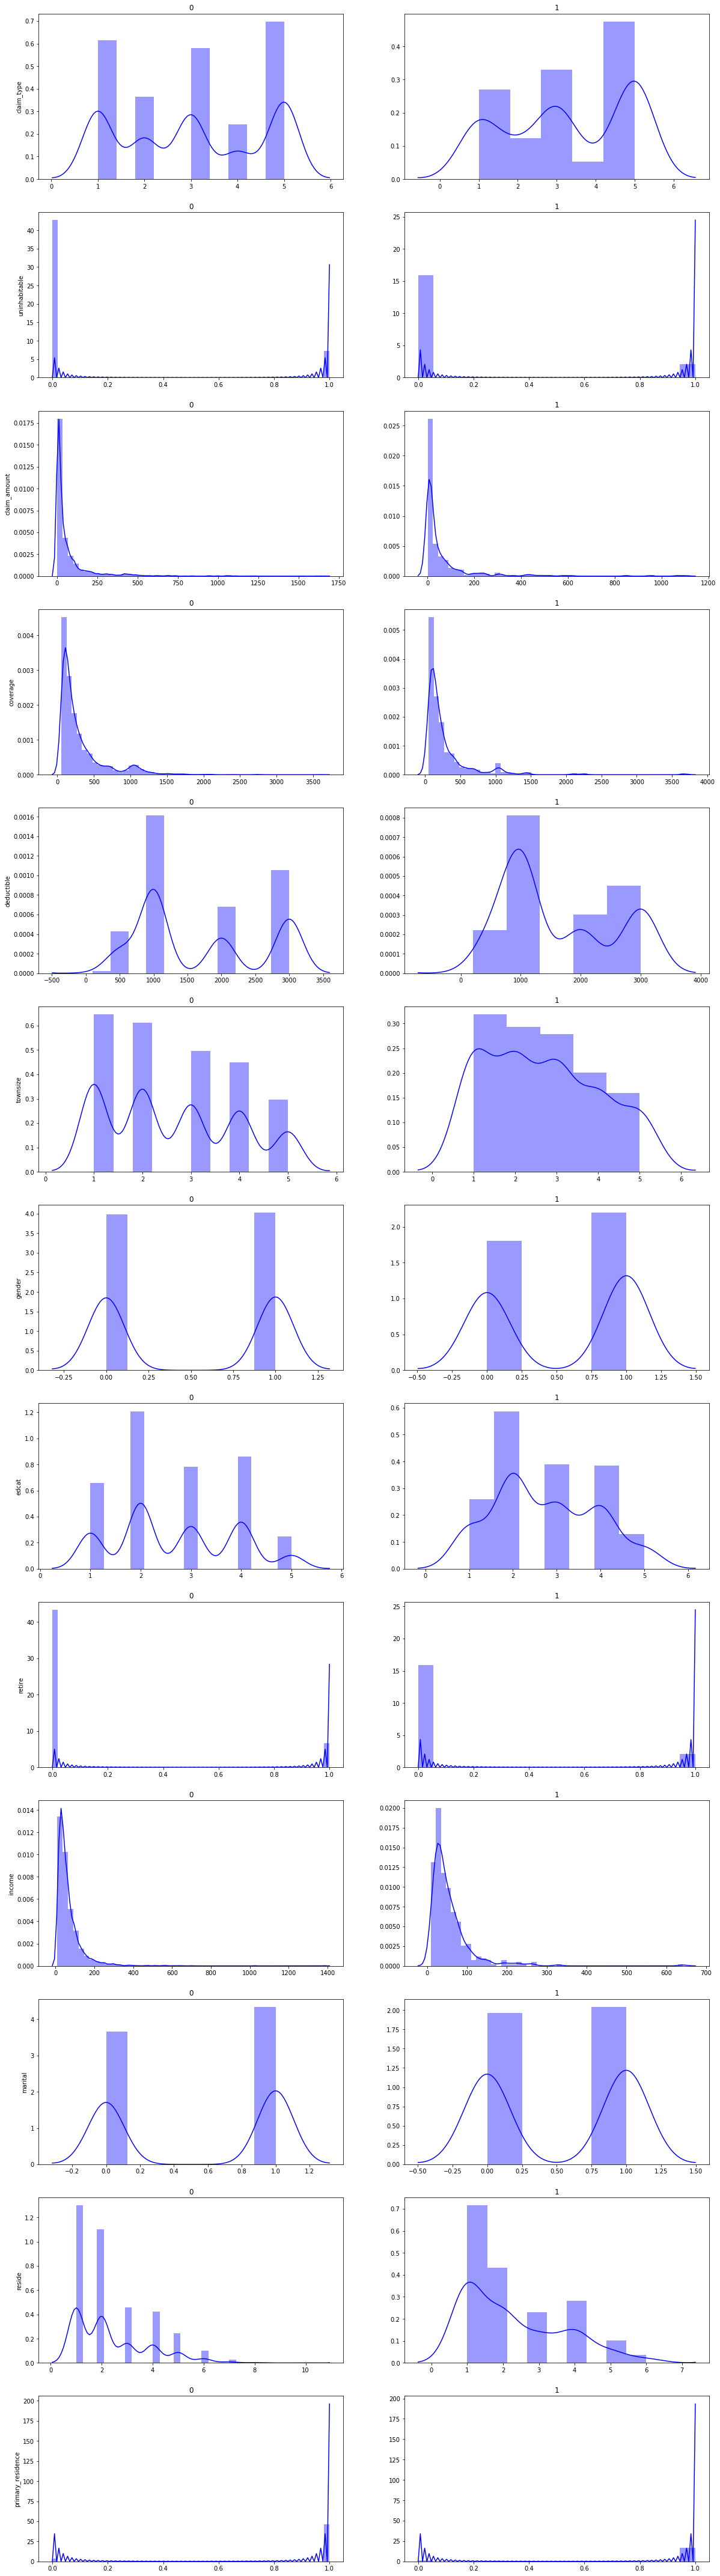

In [11]:
fig, ax = plt.subplots(len(candidates),2,figsize=(20,len(candidates)*6))
for n in range(len(candidates)):
    feat = candidates[n]
    for i in range(2):
        sns.distplot(np.array(known.loc[known['fraudulent']==i][feat]), kde=True, ax=ax[n,i], color="Blue")
        ax[n,0].set_ylabel(feat)
        ax[n,i].set_title(i)

In [12]:
xknown, yknown = np.array(known.loc[:, candidates]), np.array(known['fraudulent'])

In [25]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(xknown, yknown, train_size=0.7, random_state=1, shuffle=True)

In [26]:
RFC = ensemble.RandomForestClassifier(n_estimators=100, criterion="gini", min_samples_leaf=10, min_samples_split=3)
RFC.fit(x_train, y_train)
metrics.roc_auc_score(y_test, RFC.predict_proba(x_test).T[1])

0.5343374507129108

In [27]:
LR = LogisticRegression(penalty='elasticnet', random_state=0, solver='saga', l1_ratio=1)
LR.fit(x_train, y_train)
metrics.roc_auc_score(y_test, LR.predict_proba(x_test).T[1])

C:\Users\Dell XPS 13\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.5223403658924

In [28]:
clf = svm.SVC(probability=True)
clf.fit(x_train, y_train)
metrics.roc_auc_score(y_test, clf.predict_proba(x_test).T[0])

C:\Users\Dell XPS 13\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5239334367349989

In [31]:
clf = SGDClassifier(loss='log')
clf.fit(x_train, y_train)
metrics.roc_auc_score(y_test, clf.predict_proba(x_test).T[0])

0.5262459589258685

In [58]:
#RFC
criterions = ["gini", "entropy"]
samples_leaf, samples_split = range(1,11), range(2,12)
for criteria in criterions:
    main = []
    main_bar = tqdm(range(len(samples_leaf)))
    inside_bar = tqdm(total=(len(samples_split)))
    for i in main_bar:
        sl = samples_leaf[i]
        inside = []
        for ss in samples_split:
            x_train, x_test, y_train, y_test = model_selection.train_test_split(xknown, yknown, train_size=0.7, random_state=1, shuffle=True)
            RFC = ensemble.RandomForestClassifier(n_estimators=100, criterion=criteria, min_samples_leaf=sl, min_samples_split=ss)
            RFC.fit(x_train, y_train)
            inside.append(round(metrics.roc_auc_score(y_test, RFC.predict_proba(x_test).T[1]), 4))
            inside_bar.update()
        inside_bar.refresh()
        inside_bar.reset()
        main.append(inside)
    print("Criterion: {criteria}".format(criteria=criteria), "\n \n", np.array(main), "\n")
    del main
    main_bar.refresh()
    main_bar.reset()


Criterion: gini 
 
 [[0.5061 0.5226 0.5321 0.5145 0.5247 0.514  0.5287 0.5227 0.5424 0.5399]
 [0.5439 0.5279 0.5473 0.5261 0.5298 0.5384 0.5376 0.5461 0.528  0.5369]
 [0.5223 0.5298 0.5319 0.5447 0.5208 0.5292 0.5244 0.5133 0.536  0.5485]
 [0.5234 0.5519 0.5504 0.5346 0.5326 0.5277 0.5132 0.5524 0.5498 0.5211]
 [0.5502 0.5245 0.5372 0.532  0.5356 0.5556 0.5325 0.5274 0.5376 0.5402]
 [0.5293 0.5314 0.5578 0.5393 0.5382 0.5304 0.5353 0.5536 0.5151 0.5109]
 [0.5394 0.5612 0.5325 0.5553 0.5272 0.5302 0.523  0.5377 0.5217 0.5186]
 [0.5384 0.5281 0.5438 0.5346 0.5442 0.5392 0.5497 0.5433 0.5391 0.5292]
 [0.5404 0.536  0.5465 0.5489 0.5465 0.5283 0.5416 0.5447 0.5445 0.5315]
 [0.5344 0.5392 0.5338 0.5582 0.5552 0.5388 0.5487 0.5487 0.5316 0.5322]] 




Criterion: entropy 
 
 [[0.5377 0.5421 0.5268 0.5442 0.5375 0.5561 0.5499 0.5444 0.5451 0.5617]
 [0.5448 0.558  0.5297 0.5465 0.5368 0.5463 0.5289 0.531  0.5392 0.5301]
 [0.5554 0.5562 0.5504 0.5367 0.533  0.5409 0.556  0.5225 0.5427 0.5605]
 [0.5494 0.5431 0.5492 0.5461 0.5293 0.5448 0.5485 0.5279 0.5513 0.5426]
 [0.5288 0.5538 0.5507 0.5545 0.5407 0.5188 0.5592 0.551  0.5532 0.5452]
 [0.5491 0.5513 0.5366 0.5501 0.5457 0.5403 0.5403 0.559  0.5624 0.5434]
 [0.5317 0.5377 0.5447 0.5394 0.5589 0.5338 0.5352 0.5423 0.5413 0.5355]
 [0.5532 0.5573 0.5608 0.5454 0.5499 0.5432 0.5544 0.5552 0.5724 0.5577]
 [0.5596 0.5336 0.5417 0.5563 0.5515 0.5555 0.5534 0.5493 0.5557 0.5469]
 [0.5365 0.5379 0.5455 0.5488 0.5514 0.56   0.5759 0.5541 0.5496 0.5477]] 



In [44]:
clf = LogisticRegression(penalty='elasticnet', random_state=0, solver='saga', l1_ratio=1)
clf.fit(x_train, y_train)
probs = np.linspace(0.08, 0.1, 20)
clf_probs = list(clf.predict_proba(x_test))
for elem in probs:
    l = []
    for i in range(len(clf_probs)):
        if clf_probs[i][1] <= elem:
#             l.append(0)
            l.append(clf_probs[i][1])
        else:
#             l.append(1)
            l.append(clf_probs[i][0])
    print(round(elem, 4), round(metrics.roc_auc_score(y_test, l), 4), '\n')
    del l

C:\Users\Dell XPS 13\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.08 0.567 

0.0811 0.5677 

0.0821 0.5692 

0.0832 0.5723 

0.0842 0.5703 

0.0853 0.5755 

0.0863 0.5722 

0.0874 0.5729 

0.0884 0.5751 

0.0895 0.5788 

0.0905 0.5817 

0.0916 0.584 

0.0926 0.5862 

0.0937 0.583 

0.0947 0.5805 

0.0958 0.5819 

0.0968 0.5834 

0.0979 0.5841 

0.0989 0.5863 

0.1 0.5824 



In [41]:
xpredict, ypredict = np.array(predict.loc[:, candidates]), np.array(predict['fraudulent'])

In [46]:
clf = LogisticRegression(penalty='elasticnet', random_state=0, solver='saga', l1_ratio=1)
clf.fit(xknown, yknown)
clf_probs = list(clf.predict_proba(xpredict))
l = []
for i in range(len(clf_probs)):
    if clf_probs[i][1] <= 0.0926:
        l.append(clf_probs[i][1])
    else:
        l.append(clf_probs[i][0])
df = pd.DataFrame(np.array(l))
df.to_excel('prediction.xlsx', sheet_name='prediction')

C:\Users\Dell XPS 13\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
